In [1]:
import sys
print(f"Python version: {sys.version}")


Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


# Script to extract timeseries and check quality of the data
Includes Timeseries heatmaps, atlas fitting, report saving, GLM building
Support script : ../func.py

In [195]:
import os
import glob
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
from sklearn.utils import Bunch
from nilearn.maskers import MultiNiftiMasker, NiftiMasker, MultiNiftiLabelsMasker, MultiNiftiMapsMasker
#import datalad.api as dl
import warnings
import nibabel as nib
warnings.simplefilter('ignore')

parent_dir = os.path.abspath(os.path.join(os.path.dirname('func.py'), ".."))
sys.path.append(parent_dir)
import func

#### Load data

In [98]:
from hydra import compose, initialize
from omegaconf import OmegaConf

import os

# Initialize Hydra in notebook
initialize(config_path=".", job_name="notebook")
cfg = compose(config_name="config.yaml")

# Print the config to verify
print(OmegaConf.to_yaml(cfg))


ModuleNotFoundError: No module named 'hydra'

In [ ]:
nsub = 3

# data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'
# ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
# hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]
# behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"

# APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX
# subjects = [os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub]

# project_dir = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions'
# results_dir = os.path.join(project_dir, 'results/imaging/test_preproc') # !!!!! dataset_preproc')


setup = Bunch(
    data_dir="/data/rainville/Hypnosis_ISC/4D_data/full_run",
    ana_run=glob.glob(os.path.join("/data/rainville/Hypnosis_ISC/4D_data/full_run", 'sub*', '*analgesia*.nii.gz'))[0:nsub],
    hyper_run=glob.glob(os.path.join("/data/rainville/Hypnosis_ISC/4D_data/full_run", 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub],
    behav_path="/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx",
    APM_subjects=['APM' + sub[4:] for sub in subjects][0:nsub],  # Format to APMXX
    subjects=[os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub],
    project_dir="/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions",
    results_dir=os.path.join("/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions", 'results/imaging/test_preproc')  # Path to results
)

voxel_masker = Bunch(
    name = 'voxel_wise'
)
quality_check_save = os.path.join(project_dir, 'results', 'QC_TRs')

# Preprocessing parameters
parcel_name = 'voxel_wise' 
atlas_name = 'k50-2mm-parcel'
#parcel_type = 'labelsMasker'

masker_params_dict = {'standardize': True,
                      'detrend': True,
                      'low_pass': None,
                      'high_pass': 0.00234, # 1/428 sec.
                      't_r': 3,
                      'smoothing_fwhm': 6,
                      'standardize_confounds': True,
                      'verbose': 1,
                      'high_variance_confounds': True,
                      'mask_strategy': 'whole-brain-template', #ignore for atlas maskers
                      }

# Create save directory
preproc_model_name = '{}subjects_Zscored_detrend_FWHM6_low-pass428_{}'.format(len(subjects), datetime.today().strftime('%d-%m-%y'))
save_dir = os.path.join(setup.results_dir, preproc_model_name)
if os.path.exists(save_dir):
    print(f"The folder '{save_dir}' already exists. Results will be overwritten!!.")
    error = input("Do you want to continue? (y/n)")
else:
    os.makedirs(save_dir, exist_ok=True)



print(f"Directory {save_dir} created.")

setup.save_dir = save_dir

# subfolder_dict = {'voxel' : 'voxel_wise',
#                     'atlas' : atlas_name
#                     }
os.makedirs(os.path.join(save_dir, 'voxel_wise'), exist_ok=True)

#save the masker parameters 
masker_params_path = os.path.join(save_dir, 'preproc_params.json')
with open(masker_params_path, 'w') as f:
    json.dump(masker_params_dict, f, indent=4)

print(f"Masker parameters saved to {masker_params_path}")





The folder '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24' already exists. Results will be overwritten!!.


Directory /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24 created.
Masker parameters saved to /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/preproc_params.json


In [108]:
NiftiMasker(**).get_params()

{'detrend': True,
 'dtype': None,
 'high_pass': 0.00234,
 'high_variance_confounds': True,
 'low_pass': None,
 'mask_args': None,
 'mask_img': None,
 'mask_strategy': 'whole-brain-template',
 'memory': Memory(location=None),
 'memory_level': 1,
 'reports': True,
 'runs': None,
 'smoothing_fwhm': 6,
 'standardize': True,
 'standardize_confounds': True,
 't_r': 3,
 'target_affine': None,
 'target_shape': None,
 'verbose': 1}

# GLM and data structure

In [80]:
setup.keys(), atlas.keys(), voxel_masker.keys()

(dict_keys(['data_dir', 'ana_run', 'hyper_run', 'behav_path', 'APM_subjects', 'subjects', 'project_dir', 'results_dir', 'save_dir']),
 dict_keys(['path', 'name', 'masker_params', 'img', 'labels', 'MultiMasker']),
 dict_keys(['name', 'obj', 'save']))

#### Import and load data!

In [ ]:
# nsub = 3

# data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'

# ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
# hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]

# subjects = [os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub]
# project_dir = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions'
# behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
# APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX
# APM_subjects

['APM38', 'APM07', 'APM42']

#### Extract timestamps/events, movement files based on APM_subjects

In [171]:
import func
import importlib
importlib.reload(func) 


conditions = ['Analgesia', 'Hyperalgesia']
events_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/timestamps'
confound_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii'

# Add to bunch
setup.conditions = conditions
setup.events_dir = events_dir
setup.confound_dir = confound_dir


events_ana =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[0], return_path=False
                )
              .sort_values(by='onset')
                for sub in APM_subjects
          ]
events_ana_dct = {sub : 
                    func.get_timestamps(
                    data_dir, sub, events_dir, conditions[0], return_path=False
                )
               .sort_values(by='onset')
                    for sub in APM_subjects
                   }
# prefered dict but less easy to index
events_hyper =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[1], return_path=False
                )
               .sort_values(by='onset')
                for sub in APM_subjects
          ]
events_hyper_dct = {sub : 
                    func.get_timestamps(
                    data_dir, sub, events_dir, conditions[1], return_path=False
                )
               .sort_values(by='onset')
                    for sub in APM_subjects
                   }

#ANA run first!
confound_files=[]
for sub in APM_subjects:
    
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    #print(formatted_sub)
    # Extend the confound_files list with the matching files
    confound_files.extend(
        glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*'))
    )
    #print(glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*')))
print('len confound files : ', len(confound_files))    

cf4 = []  #extra 4 sub with diff TRs in H2/APM*/*nuis.txt
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    cf4.extend(
        glob.glob(os.path.join(confound_dir, 'H*', formatted_sub, '*_8nuisreg_*'))
    )
    
print(f'found {len(cf4)} extra irreglar-sub condound files')
confound_files.extend(cf4)

# Reorder matching APM_subjects
ordered_confound_files = []
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}"
    match = [f for f in confound_files if formatted_sub in f]
    if match:
        ordered_confound_files.append(match[0])  # Take the first match

confound_files = ordered_confound_files
confound_files_dct = {sub : file for sub, file in zip(subjects, confound_files)}
print('Total confound files : ', len(confound_files))


setup.events_dfs = {}
setup.events_dfs['Ana'] = events_ana
setup.events_dfs['Hyper'] = events_hyper
setup.confound_files = confound_files



len confound files :  3
found 0 extra irreglar-sub condound files
Total confound files :  3


Ensure same length and order of all variables

#### Split confound file based on run scans (up = Ana run, lower = Hyper run)

In [172]:

# Get the number of scans for each subject
setup.nscans = {}
setup.nscans["Ana"] = {sub: nib.load(img).shape[-1] for sub, img in zip(subjects, ana_run)}
setup.nscans["Hyper"] = {sub: nib.load(img).shape[-1] for sub, img in zip(subjects, hyper_run)}


# Split movement regressor file in two according to scan number of each 
# output loaded np arrays fir each run

ana_confounds = []
hyper_confounds = []
for i, sub in enumerate(subjects):
    
    conf_path = confound_files[i]
    confounds = np.array(pd.read_csv(conf_path, sep= '\s+', header=None))

    print(confounds.shape, type(confounds), 'len % 2 :', len(confounds)/2)
    
  
    nscan_ana = setup.nscans["Ana"][sub]
    up_ana = confounds[0:nscan_ana, :]

    nscan_hyper = setup.nscans["Hyper"][sub]
    low_hyper = confounds[nscan_ana: nscan_ana+nscan_hyper ,:]
    
    print("low_ana shape:", up_ana.shape)
    print("low_hyper shape:", low_hyper.shape)

    ana_confounds.append(up_ana)
    hyper_confounds.append(low_hyper)
    
    #up, low = split_conf_matrix(confound_files[i], nscan, run_names[i]
    #    )
setup.confound_files = confound_files
setup.confounds_Ana = ana_confounds
setup.confounds_Hyper = hyper_confounds

(754, 8) <class 'numpy.ndarray'> len % 2 : 377.0
low_ana shape: (377, 8)
low_hyper shape: (377, 8)
(744, 8) <class 'numpy.ndarray'> len % 2 : 372.0
low_ana shape: (372, 8)
low_hyper shape: (372, 8)
(754, 8) <class 'numpy.ndarray'> len % 2 : 377.0
low_ana shape: (377, 8)
low_hyper shape: (377, 8)


#### Process voxel-wise func images/timeseries


In [127]:
from importlib import reload
reload(func)

# create folders for voxel wise model : e.g. /model/voxel_wise
voxel_masker.obj = NiftiMasker(**masker_params_dict)
voxel_masker.save = os.path.join(setup.save_dir, voxel_masker.name)

ana_masked_timeseries, fitted_masks_ana = func.extract_timeseries_and_generate_individual_reports(subjects, setup.ana_run, voxel_masker.obj, voxel_masker.name, voxel_masker.save, confounds = setup.confounds_Ana, confounf_files = confound_files, condition_name="Analgesia", do_heatmap = False)

hyper_masked_timeseries, fitted_masks_hyper = func.extract_timeseries_and_generate_individual_reports(subjects, setup.hyper_run, voxel_masker.obj, voxel_masker.name, voxel_masker.save, confounds = setup.confounds_Hyper, confounf_files = confound_files,  condition_name="Hyperalgesia", do_heatmap = False)

# store 2D timeseries in subject's dict. 
voxel_masker.preproc_2d_Ana = ana_masked_timeseries #{sub : ts for sub, ts in zip(subjects, ana_masked_timeseries)}
voxel_masker.preproc_2d_Hyper = hyper_masked_timeseries #{sub : ts for sub, ts in zip(subjects, hyper_masked_timeseries)}

voxel_masker.fitted_mask_Ana = fitted_masks_ana #{sub : mask for sub, mask in zip(subjects, fitted_masks_ana)}
voxel_masker.fitted_mask_Hyper = fitted_masks_hyper #{sub : mask for sub, mask in zip(subjects, fitted_masks_hyper)}

voxel_masker.preproc_2d_cond_Descrip = 'preproc 2d timeseries for ANA and HYPER conditions and fitted masks for all volumes : 372-377 TRs/subject'

# Combine the timeseries for both runs
all_run_2d_timeseries = [np.vstack([ts1, ts2]) for ts1, ts2 in zip(voxel_masker.preproc_2d_Ana, voxel_masker.preproc_2d_Hyper)]
print(len(all_run_2d_timeseries), all_run_2d_timeseries[0].shape)

# ana_filename = os.path.join(voxel_masker.save, '{}_2d_timeseries_{}sub_Ana.npz'.format(voxel_masker.name, len(subjects)))
# hyper_filename = os.path.join(voxel_masker.save, '{}_2d_timeseries_{}sub_Hyper.npz'.format(voxel_masker.name, len(subjects)))

# #unpack dict in npz file
# np.savez_compressed(ana_filename, **voxel_masker.preproc_2d_Ana )
# np.savez_compressed(hyper_filename, **voxel_masker.preproc_2d_Hyper)

# print(f"Saved ANA timeseries to: {ana_filename}")
# print(f"Saved HYPER timeseries to: {hyper_filename}")

# ana_fitted_mask_path = os.path.join(results_dir, 'firstLevel/Ana_fittedMaskers_{}_{}-subjects.pkl'.format(parcel_name, len(subjects)))
# hyper_fitted_mask_path = os.path.join(results_dir, 'firstLevel/Hyper_fittedMaskers_{}_{}-subjects.pkl'.format(parcel_name,len(subjects)))

# with open(ana_fitted_mask_path, 'wb') as f:
#     pkl.dump(fitted_mask_ana, f)

# with open(hyper_fitted_mask_path, 'wb') as f:
#     pkl.dump(fitted_mask_hyper, f)

# print(f"Saved ANA fitted maskers to: {ana_fitted_mask_path}")
# print(f"Saved HYPER fitted maskers to: {hyper_fitted_mask_path}")



------Analgesia-----
Masker initialized with voxel_wise atlas
Processing subject sub-38...
[NiftiMasker.fit] Loading data from /data/rainville/Hypnosis_ISC/4D_data/full_run/sub-38/sub-38_analgesia_run-01_bold_4D.nii.gz
[NiftiMasker.fit] Computing the mask
[NiftiMasker.fit] Resampling mask
[NiftiMasker.fit] Finished fit
Using confound file :  /data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H1/377vol/APM_38_H1/APM38_8nuisreg_concat.txt
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-38/sub-38_analgesia_run-01_bold_4D.nii.gz')
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
Report saved for sub-38 at /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/3subjects_Zscored_detrend_FWHM6_low-pass428_02-12-24/voxel_wise/voxel_wise-report_sub-38_Analgesia.html
Processing subject su

relevant variables computed so far

setup.keys()

events_ana
events_hyper

ana_confounds
hyper_confounds

ana_filename
hyper_filename

ana_ts_dict
hyper_ts_dict



### Check TRs per condition

#### Function to count TRs for suggestion conditions, for neutral and modulation suggestion. Added to func.py file

#### Number of TRs (total condition duration / TR) TR=3 in this dataset

In [145]:
len(events_hyper), setup.save_dir

(3,
 '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24')

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              79
1  Subject_2          102              79
2  Subject_3          102              79
All subjects have the same number of TRs for both conditions.


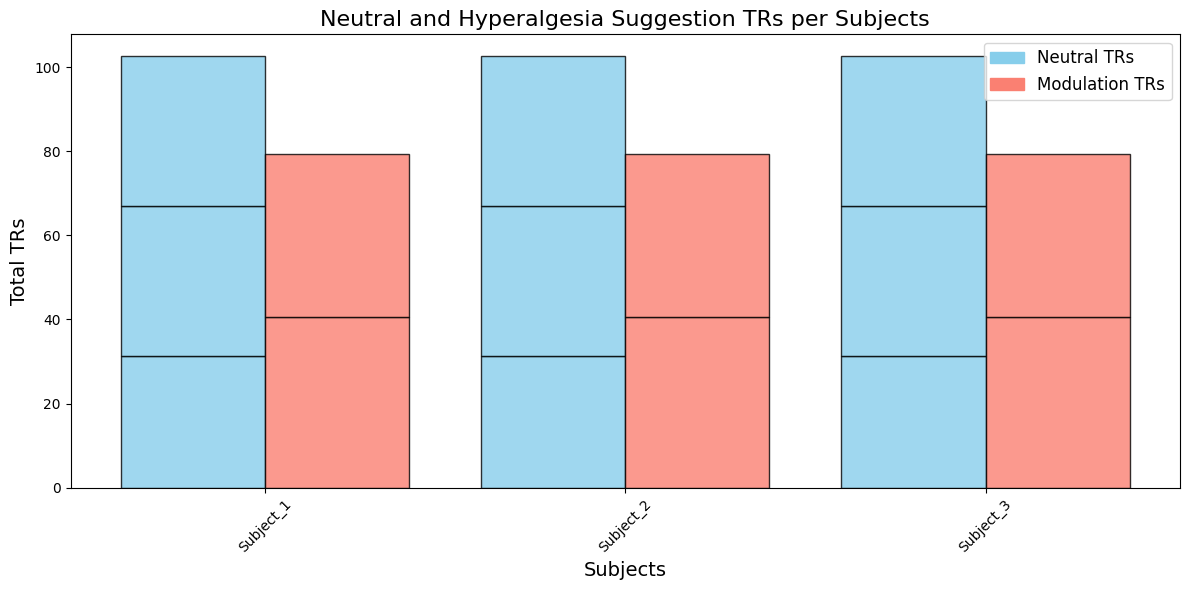

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              82
1  Subject_2          102              82
2  Subject_3          102              82
All subjects have the same number of TRs for both conditions.


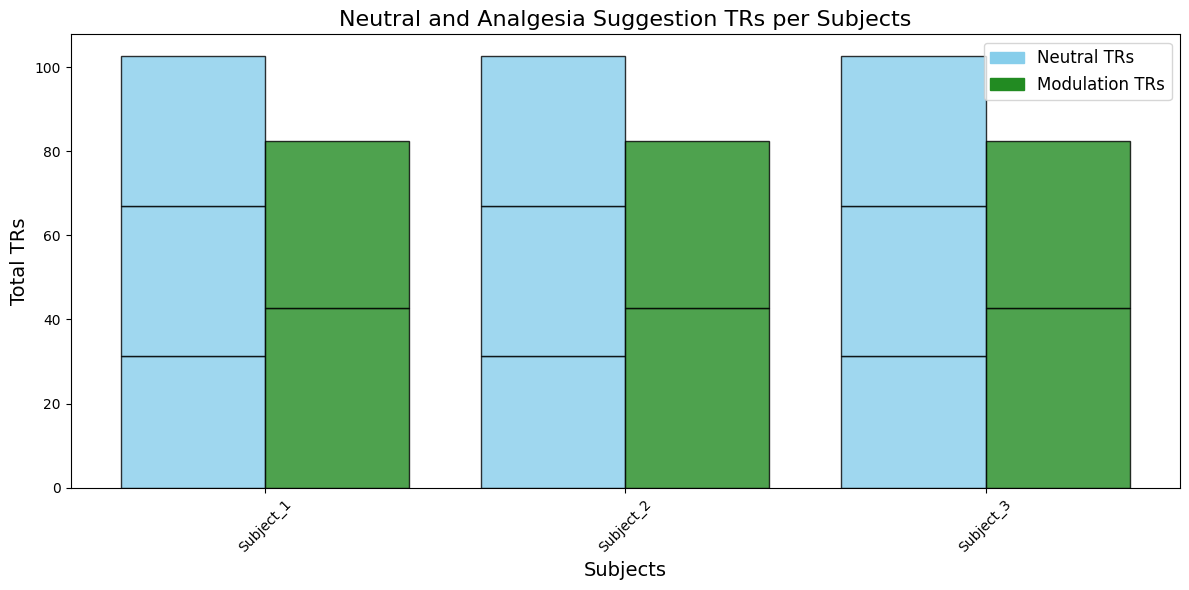

In [173]:
importlib.reload(func)


#hyper condition
TRs_df, fig_hyper = func.count_plot_TRs_2conditions(
    events_hyper,
    TR=3,
    neutral_pattern="N_HYPER.*instrbk",
    modulation_pattern="HYPER.*instrbk",
    title='Neutral and Hyperalgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="salmon",
    save_path = os.path.join(setup.save_dir, 'TRs-per-conds_Hyper_{}-subjects.png'.format(len(events_hyper)))
)

plt.close(fig_hyper)

#Ana condition
TRs_df, fig_ana = func.count_plot_TRs_2conditions(
    events_ana,
    TR=3,
    neutral_pattern="N_ANA.*instrbk",
    modulation_pattern="ANA.*instrbk",
    title='Neutral and Analgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="forestgreen",
    save_path = os.path.join(setup.save_dir, 'TRs-per-conds_Ana_{}-subjects.png'.format(len(events_ana)))
)


plt.close(fig_ana)




## First level model

events_ana
events_hyper

ana_confounds
hyper_confounds

ana
hyper_filename

ana_ts_dict
hyper_ts_dict

#### Compute and save design matrice (joint runs)
Returns dict [sub] : combined_dm

In [176]:
setup.keys(), voxel_masker.keys()

(dict_keys(['data_dir', 'ana_run', 'hyper_run', 'behav_path', 'APM_subjects', 'subjects', 'project_dir', 'results_dir', 'save_dir', 'nscans', 'confound_files', 'confounds_Ana', 'confounds_Hyper', 'conditions', 'events_dir', 'confound_dir', 'events_dfs']),
 dict_keys(['name', 'preproc_2d_Ana', 'preproc_2d_Hyper', 'fitted_mask_Ana', 'fitted_mask_Hyper', 'preproc_2d_cond_Descrip']))

Saved design matrix for subject sub-38: CSV (sub-38-Analgesia-Hyperalgesia-design_matrix.csv) and PNG (sub-38-Analgesia-Hyperalgesia-design_matrix.png).
Saved design matrix for subject sub-07: CSV (sub-07-Analgesia-Hyperalgesia-design_matrix.csv) and PNG (sub-07-Analgesia-Hyperalgesia-design_matrix.png).
Saved design matrix for subject sub-42: CSV (sub-42-Analgesia-Hyperalgesia-design_matrix.csv) and PNG (sub-42-Analgesia-Hyperalgesia-design_matrix.png).


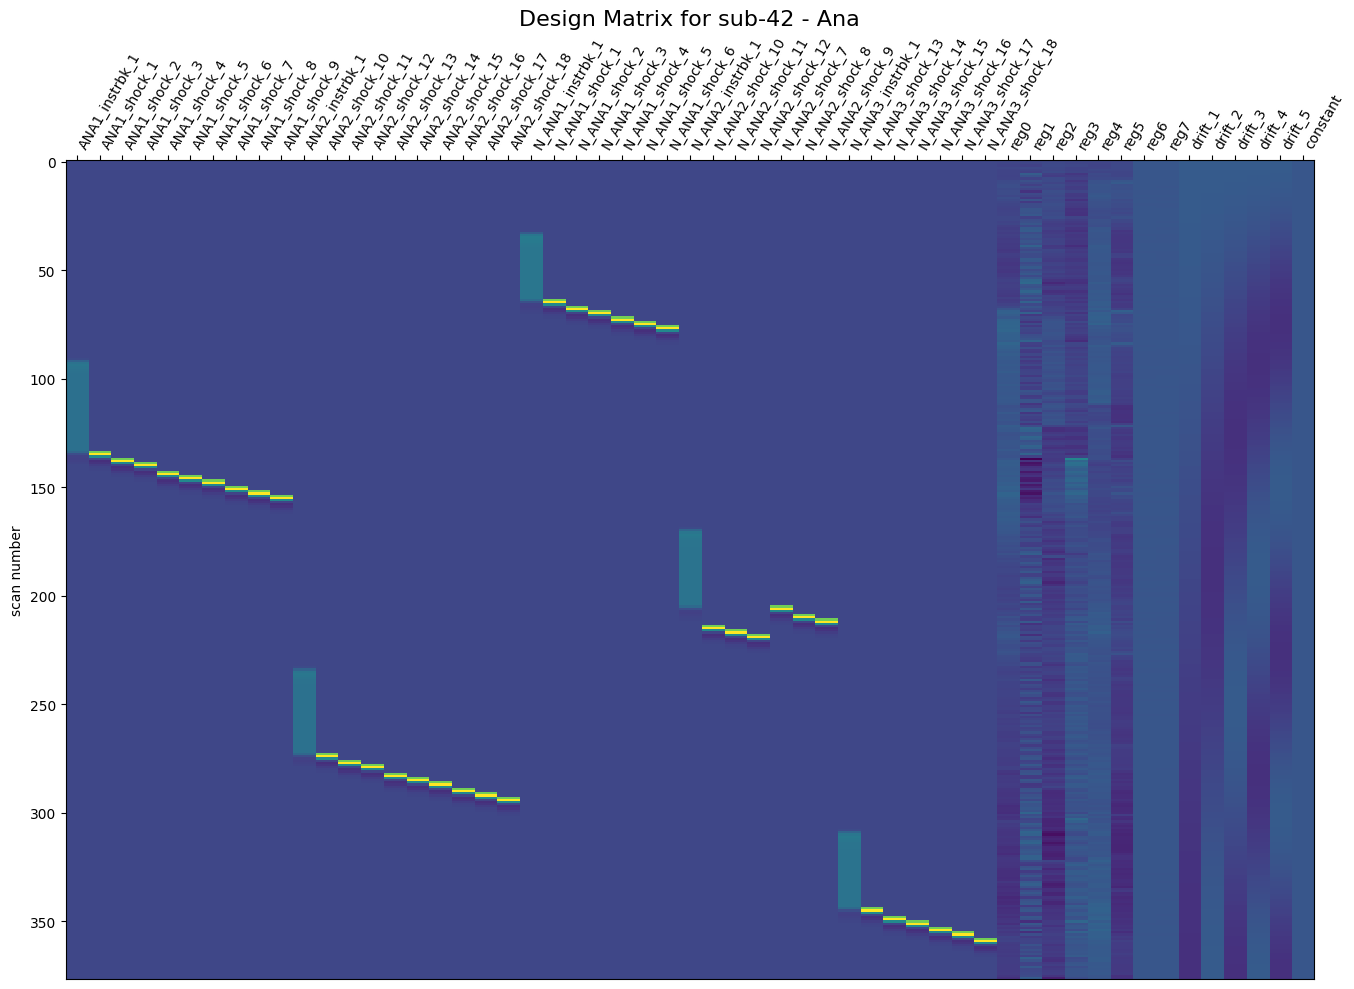

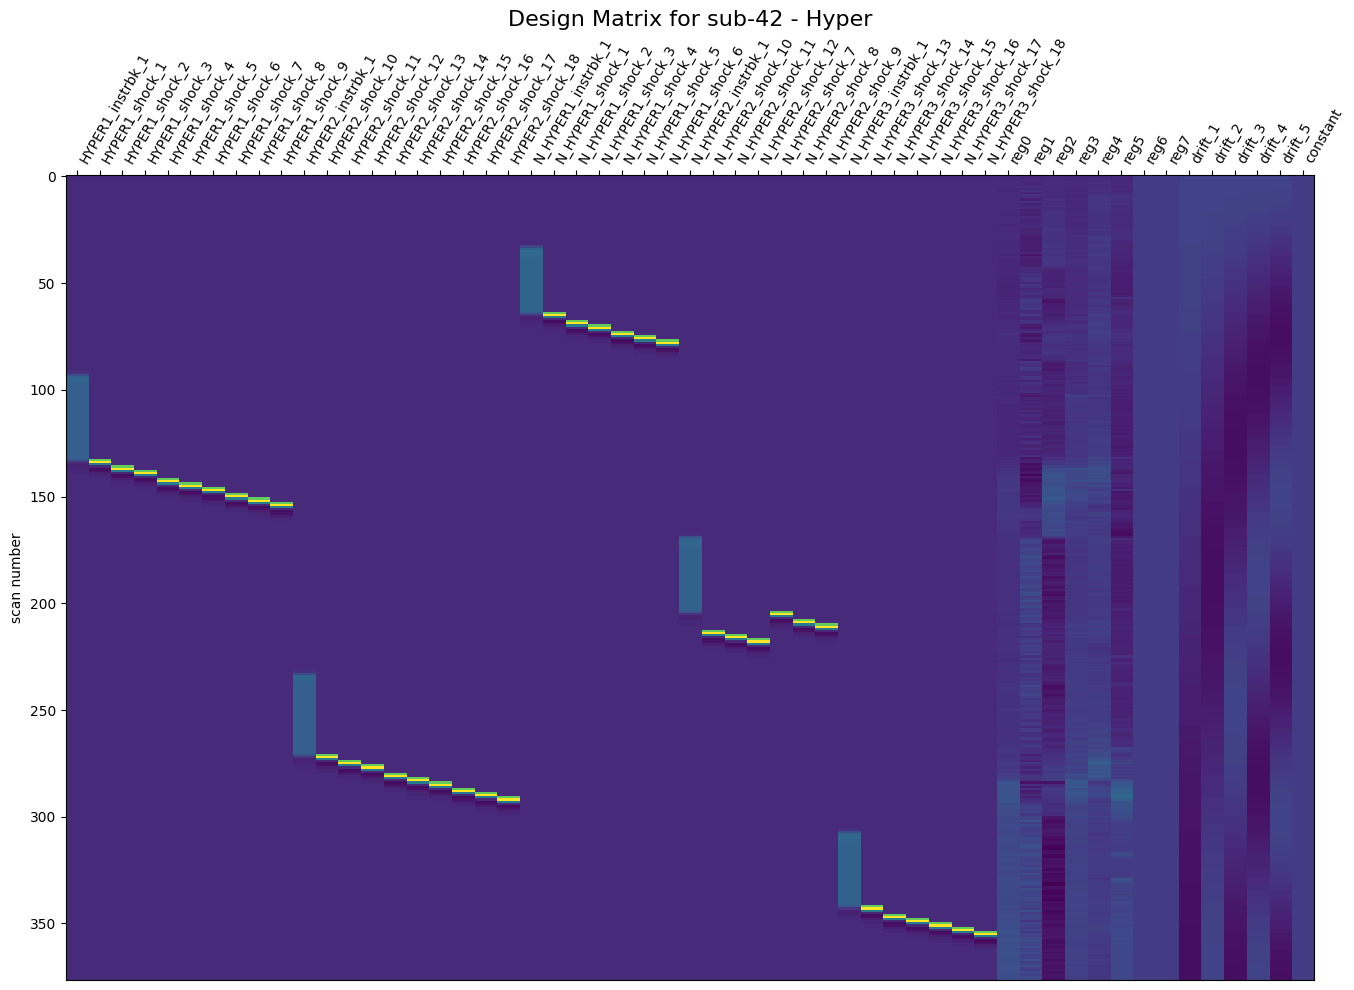

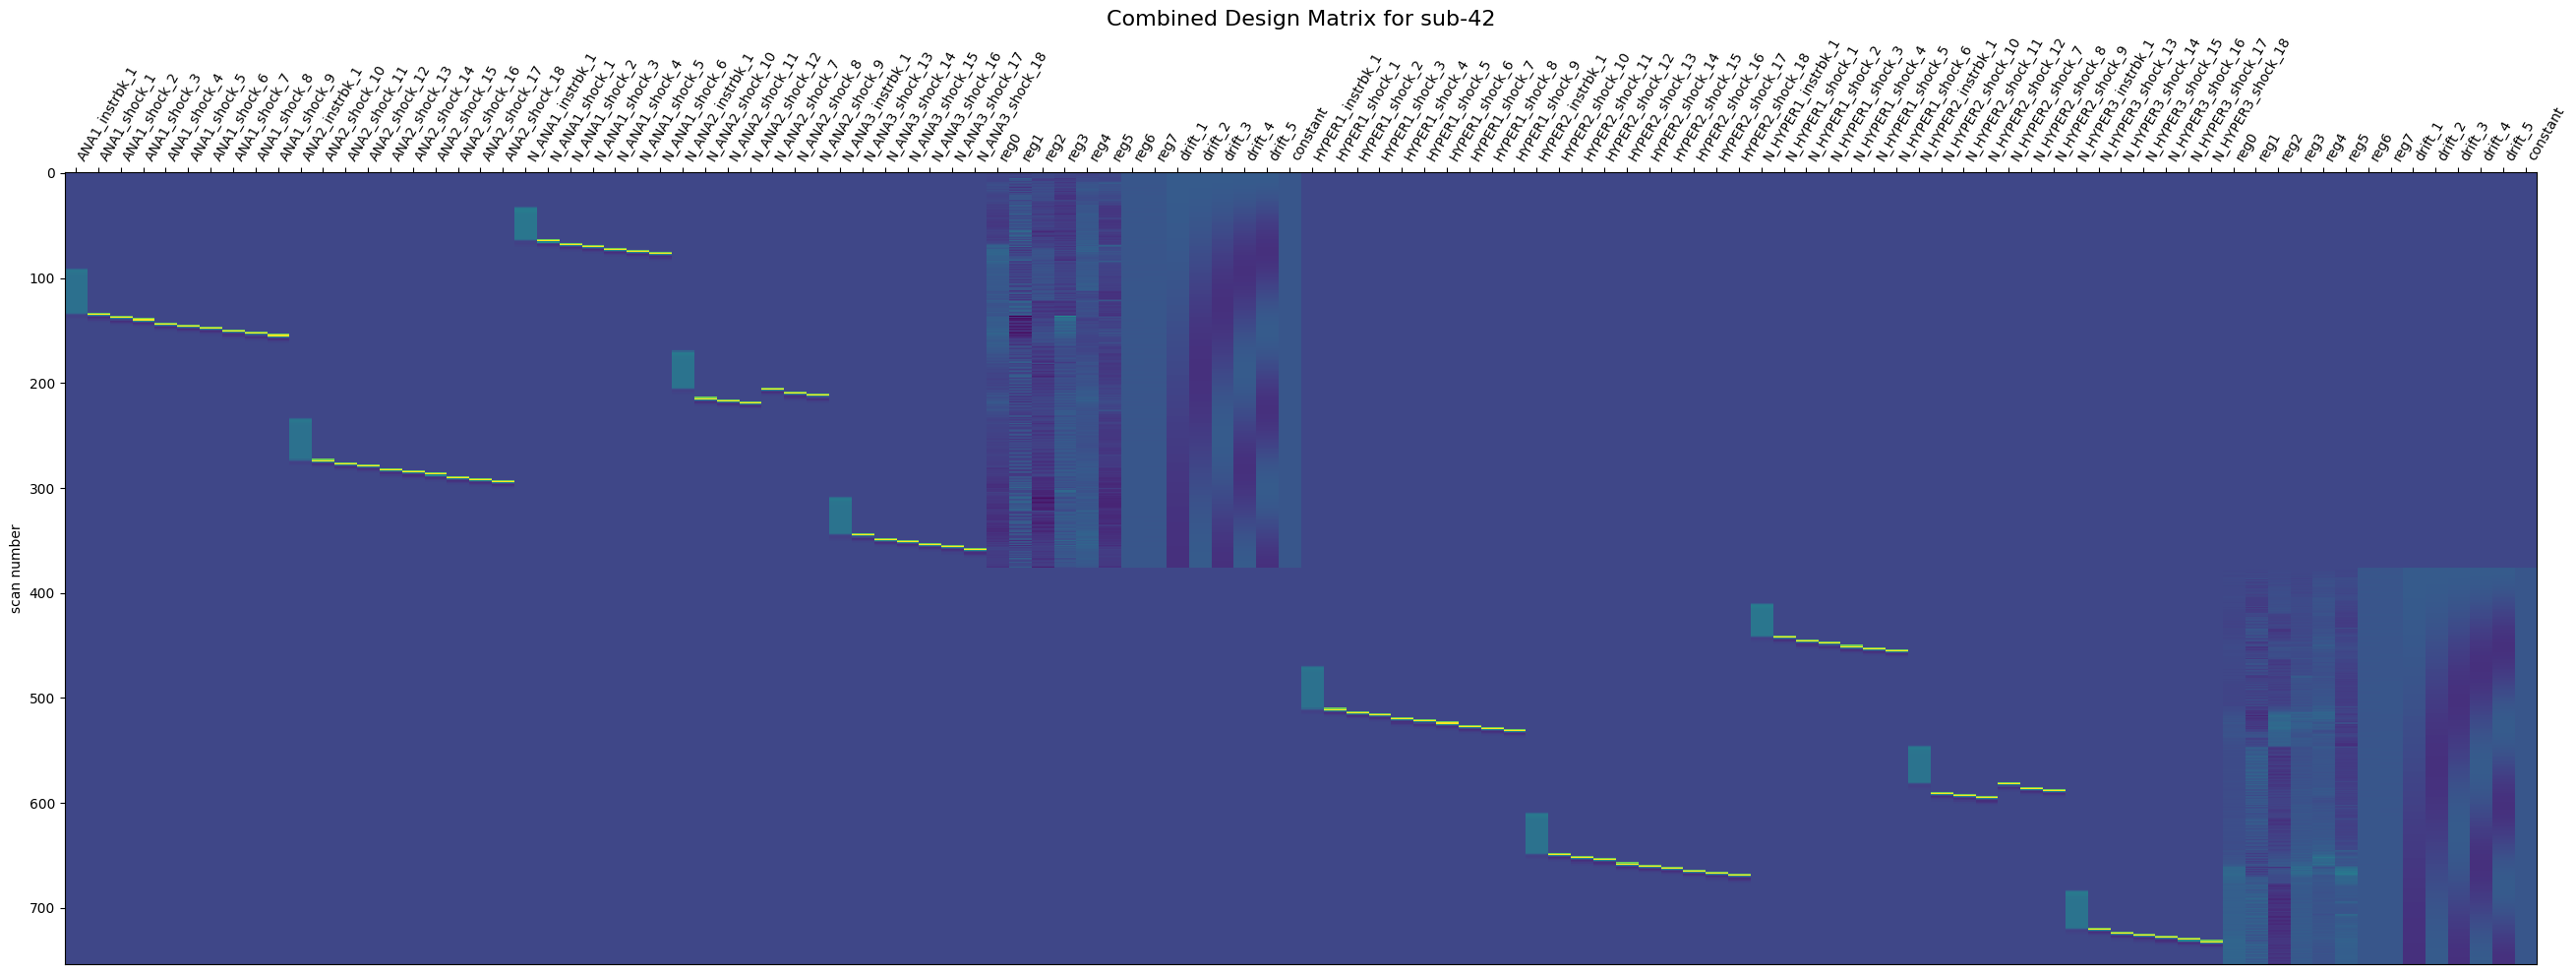

In [180]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Create a dictionary to store combined design matrices for all subjects
design_matrices_2runs = {}
design_matrices_2runs_files = []
# Directory to save design matrices
save_path = os.path.join(setup.save_dir, 'design_matrices_TxT')
os.makedirs(save_path, exist_ok=True)

for i, sub in enumerate(subjects):
    tr = masker_params_dict['t_r']
    run_names = setup.conditions

    ts_ana = voxel_masker.preproc_2d_Ana[i]
    ts_hyper = voxel_masker.preproc_2d_Hyper[i]

    nscans = ts_ana.shape[0]
    frame_time = np.arange(nscans) * tr

    # Assert that nscans match for both runs
    assert nscans == ts_hyper.shape[0], f"Mismatch in nscans for subject {sub}"

    # Create design matrices for each run
    dm_ana = make_first_level_design_matrix(
        frame_time,
        setup.events_dfs['Ana'][i],
        hrf_model='spm',
        drift_model='cosine',
        high_pass=masker_params_dict['high_pass'],
        add_regs=setup.confounds_Ana[i]
    )

    dm_hyper = make_first_level_design_matrix(
        frame_time,
        setup.events_dfs['Hyper'][i],
        hrf_model='spm',
        drift_model='cosine',
        high_pass=masker_params_dict['high_pass'],
        add_regs=setup.confounds_Hyper[i]
    )

    # Combine design matrices
    zero_padding_ana = pd.DataFrame(0, index=dm_ana.index, columns=dm_hyper.columns)
    dm_ana_padded = pd.concat([dm_ana, zero_padding_ana], axis=1)

    zero_padding_hyper = pd.DataFrame(0, index=dm_hyper.index, columns=dm_ana.columns)
    dm_hyper_padded = pd.concat([zero_padding_hyper, dm_hyper], axis=1)

    dm_combined = pd.concat([dm_ana_padded, dm_hyper_padded], axis=0)
    design_matrices_2runs[sub] = dm_combined

    # Save combined design matrix as CSV
    csv_name = f'{sub}-{"-".join(run_names)}-design_matrix.csv'
    dm_combined_csv_path = os.path.join(save_path, csv_name)
    dm_combined.to_csv(dm_combined_csv_path)
    design_matrices_2runs_files.append(dm_combined_csv_path)

    # Save combined design matrix as PNG
    png_name = f'{sub}-{"-".join(run_names)}-design_matrix.png'
    dm_combined_png_path = os.path.join(save_path, png_name)

 
    plot_design_matrix(dm_combined, rescale=True)
    plt.title(f"Combined Design Matrix for {sub}")
    plt.tight_layout()
    plt.savefig(dm_combined_png_path)
    plt.close()

    print(f"Saved design matrix for subject {sub}: CSV ({csv_name}) and PNG ({png_name}).")

    # Plot for the last subject
    if i == len(subjects) - 1:

        plot_design_matrix(dm_ana, rescale=True)
        plt.title(f"Design Matrix for {sub} - Ana", fontsize=16)
        plt.tight_layout()
        plt.show()

        plot_design_matrix(dm_hyper, rescale=True)
        plt.title(f"Design Matrix for {sub} - Hyper", fontsize=16)
        plt.tight_layout()
        plt.show()

        plot_design_matrix(dm_combined, rescale=True)
        plt.title(f"Combined Design Matrix for {sub}", fontsize=16)
        plt.tight_layout()
        plt.show()

setup.design_mat_2runs_files = design_matrices_2runs_files
#return design_matrices_2runs


### From DMs, Extract TRs for each condition, concatenate and save
Combine the timeseries for both runs

all_run_timeseries 

design_matrices_2runs

fitted_mask_ana

fitted_mask_hyper

**new*
extracted_timeseries : list of dict, 1 key for each regressor (suggestion condition)


In [182]:
import func
import importlib
importlib.reload(func)

#Extract TRs indices for regressors of all subjects (dict for each sub)
sugg_indices_all_reg = []

for sub in setup.subjects:
    print(f'==Extracting TRs indices for regressors of {sub}==')

    dm_combined = design_matrices_2runs[sub]
    cond_indices = func.create_tr_masks_for_regressors(dm_combined, regressor_names=["ANA", "N_ANA", "HYPER", "N_HYPER"])
    sugg_indices_all_reg.append(cond_indices)


# Extract the timeseries for each condition
print('====Extracting volumes per regressor for all subjects====')

extracted_timeseries_per_cond = []
cond_names = ["ANA", "N_ANA", "HYPER", "N_HYPER"]

for i, sub in enumerate(subjects):
    
    print(f"Extracted timeseries for subject {sub}: {cond_names}")
    dct_timeseries = func.extract_regressor_timeseries(all_run_2d_timeseries[i], sugg_indices_all_reg[i])
    extracted_timeseries_per_cond.append(dct_timeseries)

print(f"Extracted timeseries for all subjects: {cond_names}")




==Extracting TRs indices for regressors of sub-38==
Including regressors : {'ANA1_instrbk_1', 'ANA2_instrbk_1'}
Including regressors : {'N_ANA1_instrbk_1', 'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER1_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER2_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-07==
Including regressors : {'ANA1_instrbk_1', 'ANA2_instrbk_1'}
Including regressors : {'N_ANA1_instrbk_1', 'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER1_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER2_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-42==
Including regressors : {'ANA1_instrbk_1', 'ANA2_instrbk_1'}
Includ

#### Save concatenated timeseries for each condition

output func_imgs_paths : list of dict contan

In [185]:
voxel_masker.keys()

dict_keys(['name', 'preproc_2d_Ana', 'preproc_2d_Hyper', 'fitted_mask_Ana', 'fitted_mask_Hyper', 'preproc_2d_cond_Descrip'])

In [186]:

# Save the 4D NIfTI files for each condition
save_dir_4D = os.path.join(setup.save_dir, 'suggestion_blocks_concat_4D')
os.makedirs(save_dir_4D, exist_ok=True)

func_imgs_paths = {}

# reconstruct the 4D nifti files for each subject
for i, sub in enumerate(setup.subjects): 
    print(f'[{sub}] : Inverse transforming timeseries for cond {list(cond_names)}')
    cond_names = extracted_timeseries_per_cond[i].keys()

    func_cond_paths = []
    sub_imgs_shape = []

    for ncond, cond in enumerate(cond_names):
    
        if 'ANA' in cond:
            masker = voxel_masker.fitted_mask_Ana[i]
        elif 'HYPER' in cond:
            masker = voxel_masker.fitted_mask_Hyper[i]
        
        
        timeseries = extracted_timeseries_per_cond[i][cond]
        nifti_images = masker.inverse_transform(timeseries)

        sub_imgs_shape.append(nifti_images.shape[-1])
        
        # Save as NIfTI file
        cond_folder = os.path.join(save_dir_4D, cond)
        os.makedirs(cond_folder, exist_ok=True)
        
        img_save_path = os.path.join(cond_folder, f"{sub}_{nifti_images.shape[-1]}-vol_{cond}.nii.gz")
        nifti_images.to_filename(img_save_path)
        func_cond_paths.append(img_save_path)

    func_imgs_paths[sub] = func_cond_paths # save func path in sub's dict


    print(f"    {sub} saved {ncond} nifti  with {sub_imgs_shape} volumes")
    

[sub-38] : Inverse transforming timeseries for cond ['ANA', 'N_ANA', 'HYPER', 'N_HYPER']
    sub-38 saved 3 nifti  with [87, 110, 84, 110] volumes
[sub-07] : Inverse transforming timeseries for cond ['ANA', 'N_ANA', 'HYPER', 'N_HYPER']
    sub-07 saved 3 nifti  with [87, 110, 84, 110] volumes
[sub-42] : Inverse transforming timeseries for cond ['ANA', 'N_ANA', 'HYPER', 'N_HYPER']
    sub-42 saved 3 nifti  with [87, 110, 84, 110] volumes


### Gather all image filenames/paths in lists. One per condition

In [189]:
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map, view_img
import os
import matplotlib.pyplot as plt

# Initialize a dictionary to store concatenated images for each condition
condition_concat_imgs = {cond: [] for cond in ["ANA", "N_ANA", "HYPER", "N_HYPER"]}


# append all func img path for each condition in a list
for sub, func_imgs_ls in func_imgs_paths.items():
    print(f"Processing subject {sub}")
    for cond_index, condition in enumerate(condition_concat_imgs.keys()):
        func_img_path = func_imgs_ls[cond_index]
        condition_concat_imgs[condition].append(func_img_path)
        print(f"Condition: {condition}, Subject: {sub}, Image: {func_img_path}")

setup.suggestion_imgs_files = condition_concat_imgs


Processing subject sub-38
Condition: ANA, Subject: sub-38, Image: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D/ANA/sub-38_87-vol_ANA.nii.gz
Condition: N_ANA, Subject: sub-38, Image: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D/N_ANA/sub-38_110-vol_N_ANA.nii.gz
Condition: HYPER, Subject: sub-38, Image: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D/HYPER/sub-38_84-vol_HYPER.nii.gz
Condition: N_HYPER, Subject: sub-38, Image: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/suggestion_blocks_concat_4D/N_HYPER/sub-38_110-vol_N_H


Computing mean image for condition: ANA


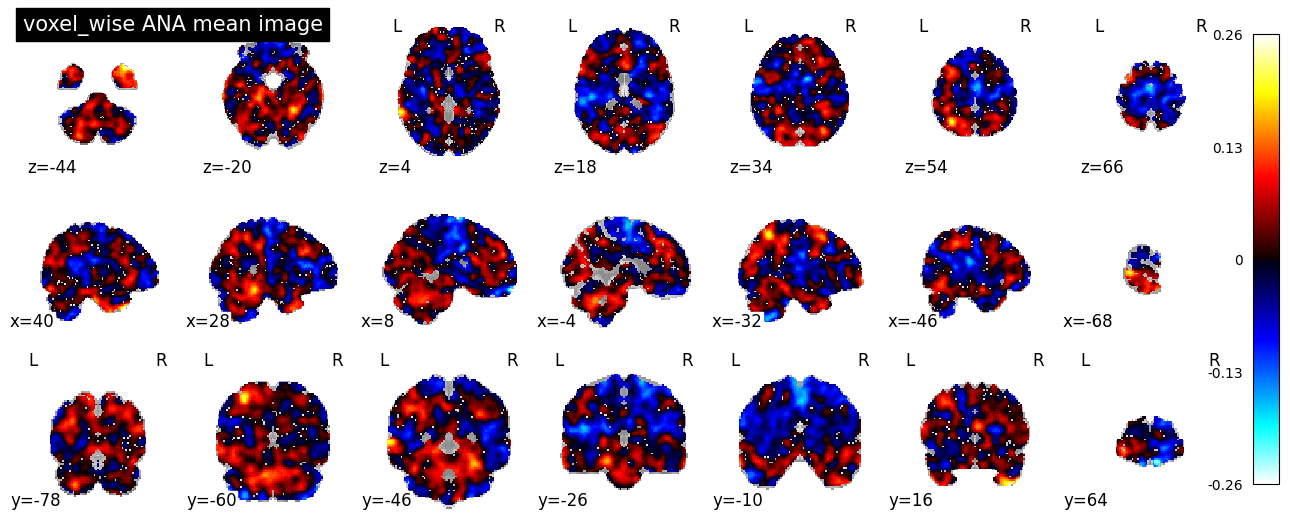

Mean image for condition ANA saved at: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/voxel_wise/voxel_wise-mean_img_ANA_3-subjects.png

Computing mean image for condition: N_ANA


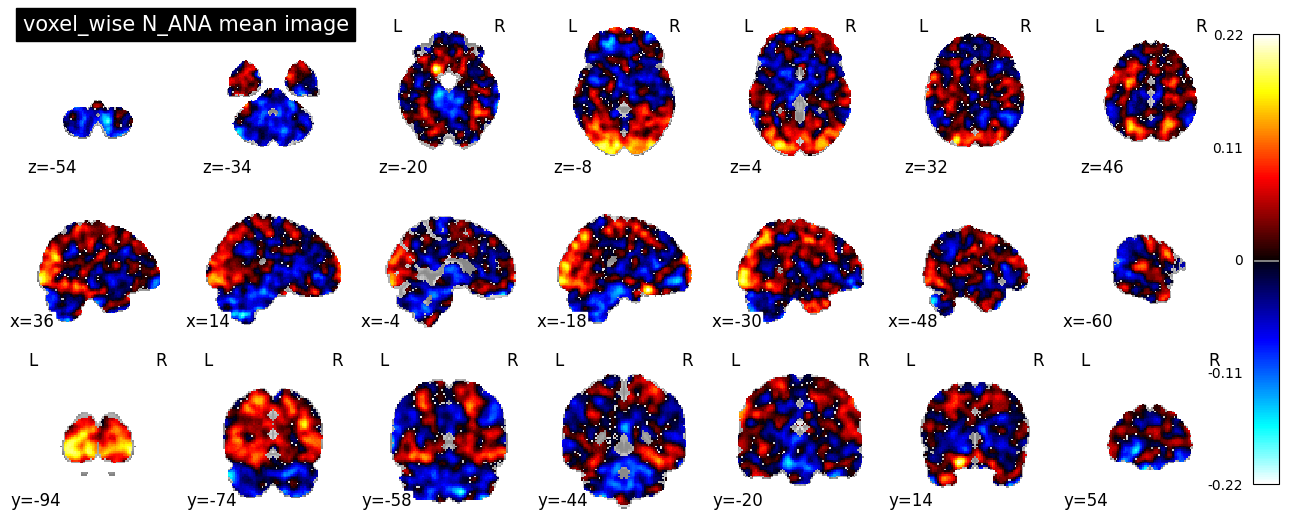

Mean image for condition N_ANA saved at: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/voxel_wise/voxel_wise-mean_img_N_ANA_3-subjects.png

Computing mean image for condition: HYPER


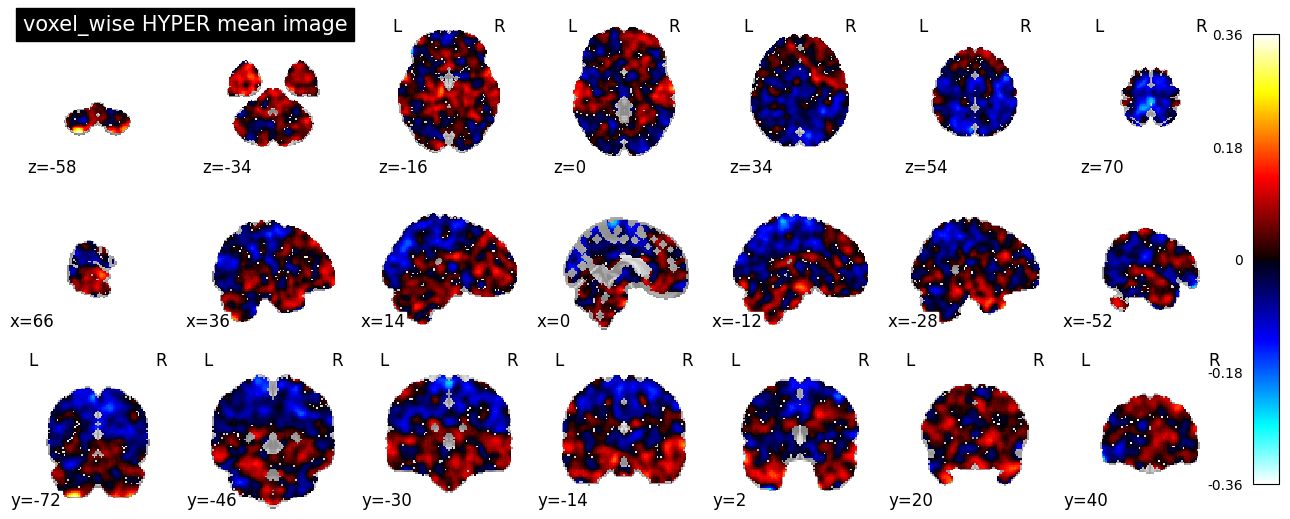

Mean image for condition HYPER saved at: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/voxel_wise/voxel_wise-mean_img_HYPER_3-subjects.png

Computing mean image for condition: N_HYPER


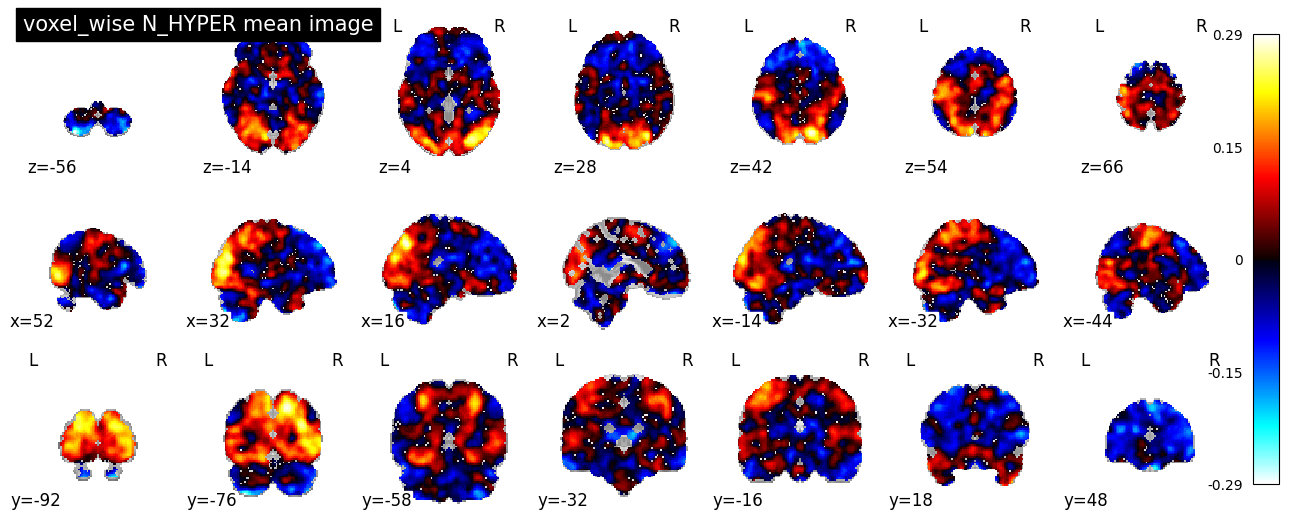

Mean image for condition N_HYPER saved at: /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/voxel_wise/voxel_wise-mean_img_N_HYPER_3-subjects.png

All mean images saved in /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/glm_suggestion


In [ ]:
# mean images for each condition and plot

for condition, img_paths in condition_concat_imgs.items():
    print(f"\nComputing mean image for condition: {condition}")
    

    mean_condition_img = mean_img(img_paths)
    
    # Plot and save the mean image
    display = plot_stat_map(
        mean_condition_img,
        title=f"{voxel_masker.name} {condition} mean image",
        display_mode="mosaic",
        threshold=1e-3,
        dim=0.8,
    )
    
    #html_view = view_img(mean_condition_img, threshold='98%', cut_coords=[-42, -16, 52])

    mean_image_path = os.path.join(voxel_masker.save, f"{voxel_masker.name}-mean_img_{condition}_{len(img_paths)}-subjects.png")
    display.savefig(mean_image_path)
    plt.show()
    plt.close()

    print(f"Mean image for condition {condition} saved at: {mean_image_path}")

print(f"\nAll mean images saved in {mean_image_save_dir}")



# Parcellation and ROI extraction

## Quality check on ROI timeseries

#### **Probabilistic atlas**

(array([ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.00000001,  6.99999999,  8.        ,  9.        ,
       10.        , 11.        , 12.        , 13.        , 14.        ,
       15.        , 16.        , 17.        , 18.00000001, 18.99999999,
       20.        , 21.        , 22.        , 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.00000001, 31.99999999, 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.00000001, 43.99999999,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       49.99999999]), array([751102,   1746,   2929,   6376,   2952,   2786,   3383,   4862,
         2622,   4809,   1988,   3130,   2629,   1870,   2432,  11709,
         3343,   4017,   2275,   1095,   4350,   3187,   1743,   1250,
         5359,   5557,   5411,   1667,   221

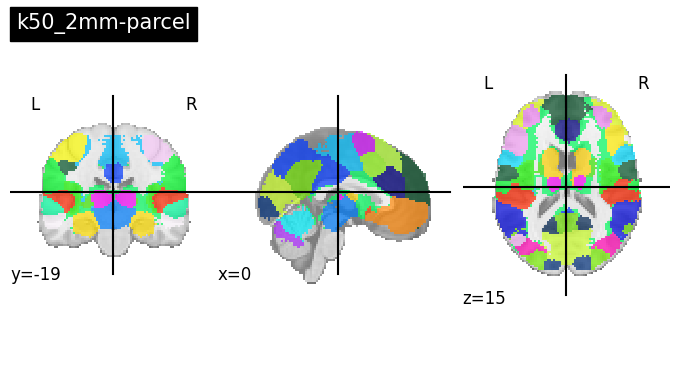

In [196]:
from nilearn.image import load_img
from nilearn.plotting import plot_roi
from nilearn.maskers import MultiNiftiLabelsMasker

#  atlas-related variables 
atlas = {
    "path": os.path.join(project_dir, 'masks', 'k50_2mm.nii/', '*.nii'),
    "name": "k50_2mm-parcel",
    'masker_params' : masker_params_dict
}

atlas["img"] = load_img(atlas["path"])

# Plot the atlas ROI
plot_roi(atlas["img"], title=atlas["name"])
print(np.unique(atlas["img"].get_fdata(), return_counts=True))

# Prepare masker using the parameters in the dictionary
atlas["labels"] = np.unique(atlas["img"].get_fdata() + 1)

atlas["MultiMasker"] = MultiNiftiLabelsMasker(
    atlas["img"],
    labels=atlas["labels"],
    **atlas["masker_params"]
)

# Print masker parameters for verification
print(atlas["MultiMasker"].get_params())


##### DiFuMo64

In [ ]:
atlas_path = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/masks/DiFuMo256/3mm/maps.nii.gz'
atlas_dict_path = '/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/masks/DiFuMo256/labels_256_dictionary.csv'
atlas = nib.load(atlas_path)
atlas_df = pd.read_csv(atlas_dict_path)
print('atlas loaded with N ROI : ', atlas.shape)

atlas loaded with N ROI :  (104, 123, 104, 256)


## Apply parcellation and plot reports
1) group
2) individual report + ROI x TRs heatmaps

In [197]:
atlas['img'].shape

(91, 109, 91, 1)

#### 1) Group masker fitting on atlas

#### Apply group label masker and generate report

In [ ]:

func.generate_multinifti_report(setup, mask_nifti, project_dir, condition_name="Analgesia")
func.generate_multinifti_report(hyper_run, mask_nifti, project_dir, condition_name="Hyperalgesia")


Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Analgesia_MultiNiftiLabels_ROI/MultiLabels_report_Analgesia.html
Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Hyperalgesia_MultiNiftiLabels_ROI/MultiLabels_report_Hyperalgesia.html


#### 2) Individual atlas report (label masker)
-->Save ROI x TRs heatmap + individual LabelMasker report in /results/cond/

#### Generate and save individual report and heatmaps for two runs

In [ ]:

label_masker = NiftiLabelsMasker(mask_nifti, standardize=True, detrend=True)
masker_params = label_masker.get_params()

parcel_name = 'k50-2mm-parcel'

ana_masked_timeseries, fitted_mask_ana = func.extract_timeseries_and_generate_individual_reports(subjects, ana_run, label_masker, parcel_name, project_dir, condition_name="Analgesia")

hyper_masked_timeseries, fitted_mask_hyper = func.extract_timeseries_and_generate_individual_reports(subjects, hyper_run, label_masker, parcel_name, project_dir, condition_name="Hyperalgesia")



------Analgesia-----
Masker initialized with k50-2mm-parcel mask
Processing subject sub-38...
Report saved for sub-38 at /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/k50-2mm-parcel_reports_Analgesia_3-subjects/k50-2mm-parcel-ROI-report_sub-38_Analgesia.html
Heatmap saved for sub-38 at /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/k50-2mm-parcel_reports_Analgesia_3-subjects/k50-2mm-parcel-ROI_heatmap_sub-38_Analgesia.png
Processing subject sub-07...
Report saved for sub-07 at /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/k50-2mm-parcel_reports_Analgesia_3-subjects/k50-2mm-parcel-ROI-report_sub-07_Analgesia.html
Heatmap saved for sub-07 at /data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/k50-2mm-parcel_reports_Analgesia_3-subjects/k50-2mm-parcel-ROI_heatmap_sub-07_Analgesia.png
Processing subject sub-42...
Report saved for sub-42 at /data/rainville/dSutterlin/projects

### Save masked timeseries and fitted masker

In [ ]:
from importlib import reload
reload(func)

results_dir = os.path.join(project_dir, 'results/imaging')
ana_ts_dict = {sub : ts for sub, ts in zip(subjects, ana_masked_timeseries)}
hyper_ts_dict = {sub : ts for sub, ts in zip(subjects, hyper_masked_timeseries)}

ana_filename = os.path.join(results_dir, 'firstLevel/ana_masked_{}sub.npz'.format(len(subjects)))
hyper_filename = os.path.join(results_dir, 'firstLevel/hyper_masked_{}sub.npz'.format(len(subjects)))

np.savez_compressed(ana_filename, **ana_ts_dict)
np.savez_compressed(hyper_filename, **hyper_ts_dict)

print(f"Saved ANA timeseries to: {ana_filename}")
print(f"Saved HYPER timeseries to: {hyper_filename}")

ana_fitted_mask_path = os.path.join(results_dir, 'firstLevel/Ana_fittedMaskers_{}_{}-subjects.pkl'.format(parcel_name, len(subjects)))
hyper_fitted_mask_path = os.path.join(results_dir, 'firstLevel/Hyper_fittedMaskers_{}_{}-subjects.pkl'.format(parcel_name,len(subjects)))

with open(ana_fitted_mask_path, 'wb') as f:
    pkl.dump(fitted_mask_ana, f)

with open(hyper_fitted_mask_path, 'wb') as f:
    pkl.dump(fitted_mask_hyper, f)

print(f"Saved ANA fitted maskers to: {ana_fitted_mask_path}")
print(f"Saved HYPER fitted maskers to: {hyper_fitted_mask_path}")


NameError: name 'ana_masked_timeseries' is not defined

create a list containing all run timeseries 2d arrays for all subjects [sub_1(total TRs X ROi)...]

In [192]:
all_sugg_timeseries_per_sub = []
for i in range(len(subjects)):
    ts1, ts2, ts3, ts4 = [extracted_timeseries_per_cond[i][cond] for cond in cond_names]
    all_sugg_timeseries_per_sub.append(np.vstack([ts1, ts2, ts3, ts4]))


Parameter ID: 7607


NameError: name 'masker_params' is not defined

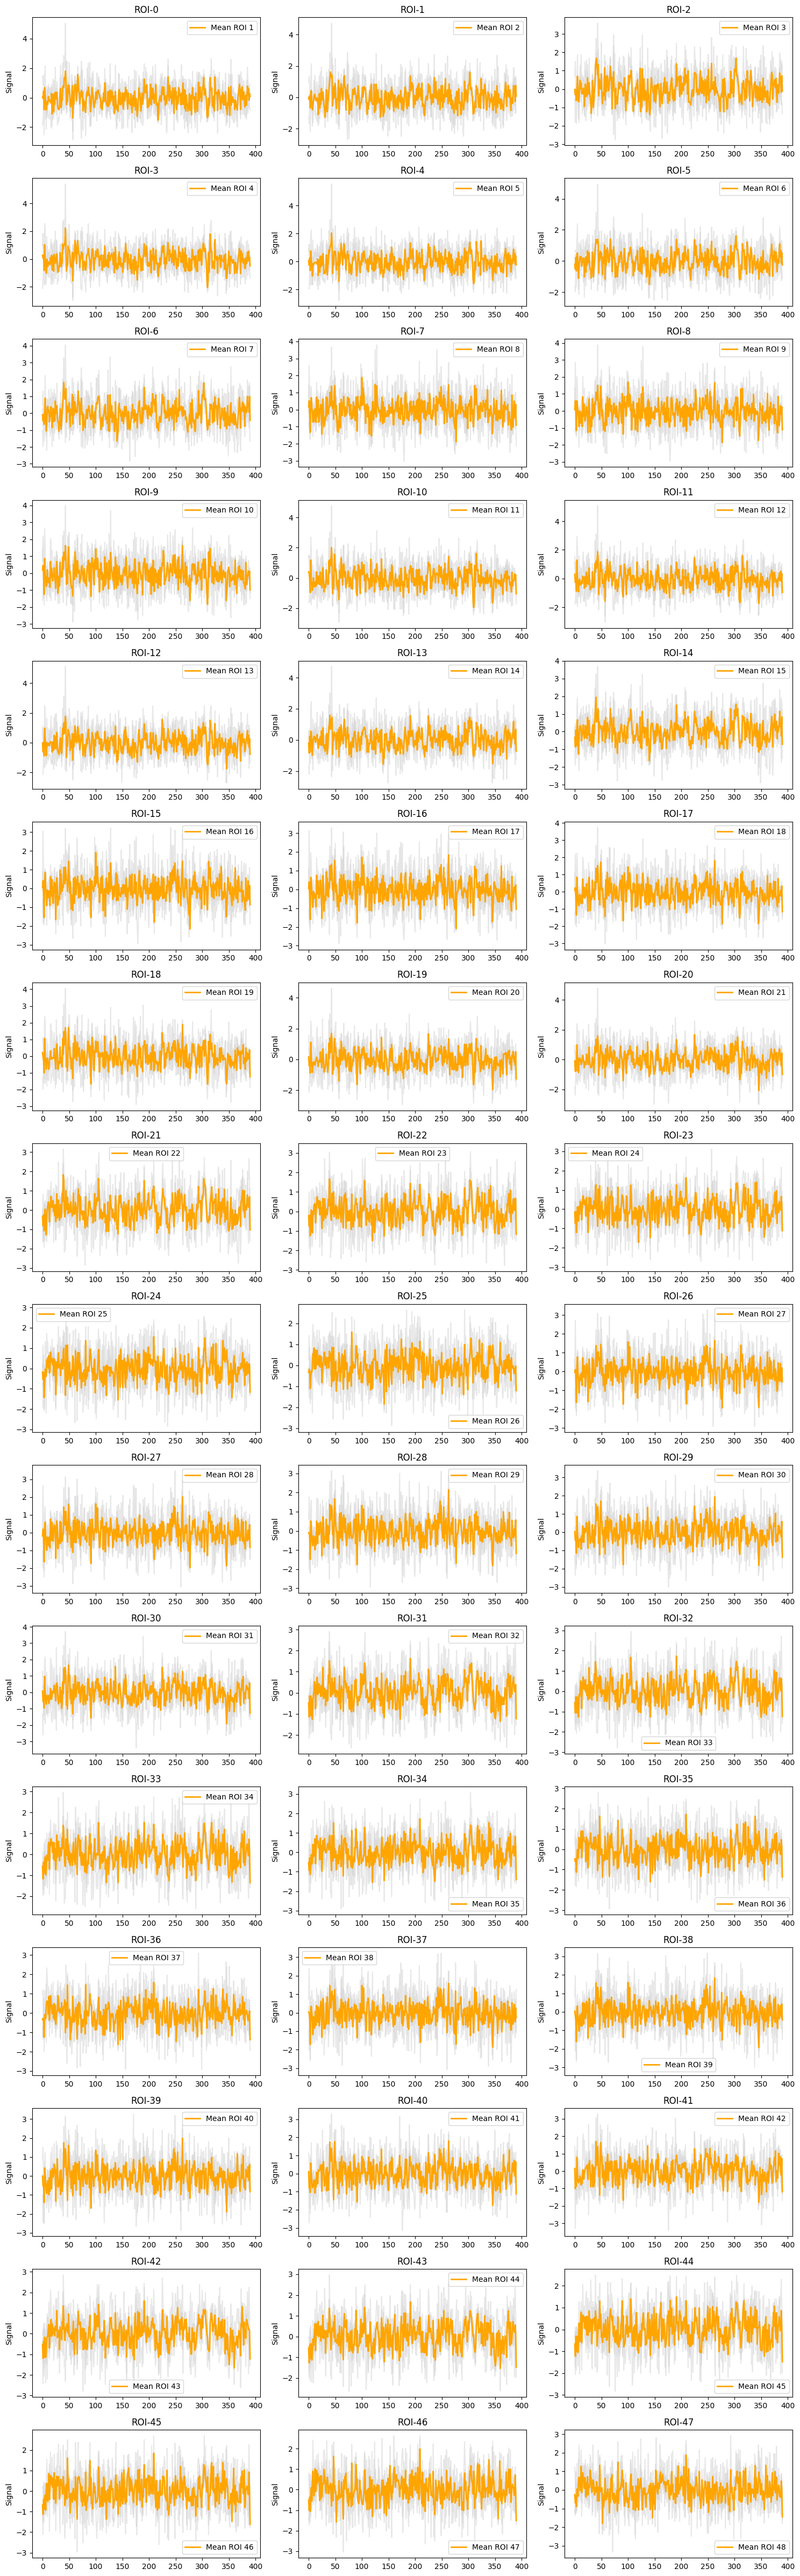

In [193]:
importlib.reload(func)
import json

n_rois = all_run_2d_timeseries[0].shape[-1]
roi_names = [f'ROI-{idx}' for idx in range(n_rois)]

param_id = np.random.randint(0, 10000)
print(f"Parameter ID: {param_id}")
save_to = os.path.join(quality_check_save, 'mean_timecourses-ROIs',f'{parcel_name}_mean_timecourses-paramId-{param_id}')
os.makedirs(save_to, exist_ok=True)

save_name = 'mean_timecourses-ROIs_allSubj.png'
func.plot_timecourses_from_ls(all_sugg_timeseries_per_sub, roi_names, save_to = False, n_rows=16, n_cols=3)

#save masker params
masker_params_path = os.path.join(quality_check_save, f'{parcel_name}_masker_paramId-{param_id}.txt')
func.write_masker_params(masker_params, masker_params_path)


Mean images

In [206]:
voxel_masker.save, voxel_masker.name #keys()

('/data/rainville/dSutterlin/projects/ISC_hypnotic_suggestions/results/imaging/test_preproc/3subjects_Zscored_detrend_FWHM6_low-pass428_03-12-24/voxel_wise',
 'voxel_wise')

In [65]:
# extract TRs for each condition
condition_keys = ['ANA', 'N_ANA', 'HYPER', 'N_HYPER']
condition = 'N_ANA'


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np

def create_design_matrix(events, confounds_file, TR, n_scans, title):
    """
    Create and plot a design matrix for one run.

    Parameters:
    -----------
    events : pd.DataFrame
        DataFrame containing onset, duration, and trial_type columns for the run.

    confounds_file : str
        Path to the confounds file for the run.

    TR : int
        Repetition time (TR) in seconds.

    n_scans : int
        Number of scans in the fMRI run.

    title : str
        Title for the design matrix plot.

    Returns:
    --------
    design_matrix : pd.DataFrame
        The design matrix for the run.

    fig : matplotlib.figure.Figure
        The figure object of the design matrix plot.
    """
    # Frame times for each TR
    frame_times = np.arange(n_scans) * TR


    # Create the design matrix
    design_matrix = make_first_level_design_matrix(
        frame_times=frame_times,
        events=events,
        add_regs=confounds.values,
        add_reg_names=confounds.columns
    )

    # Plot the design matrix
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_design_matrix(design_matrix, ax=ax)
    ax.set_title(title)
    plt.tight_layout()

    return design_matrix, fig


# Parameters for one subject
TR = 3  # Adjust based on your fMRI TR
n_scans_hyper = 200  # Adjust based on the number of scans in the hyper run
n_scans_ana = 180  # Adjust based on the number of scans in the analgesia run

subject_index = 0  # Replace with the desired subject index

# Paths to confounds
confounds_hyper = hyper_run[subject_index]
confounds_ana = ana_run[subject_index]

# Events for hyper and analgesia runs
events_hyper_subject = events_hyper[subject_index]
events_ana_subject = events_ana[subject_index]

# Create and plot the design matrix for the hyper run
dm_hyper, fig_hyper = create_design_matrix(
    events_hyper_subject,
    confounds_hyper,
    TR,
    n_scans_hyper,
    "Design Matrix for Hyper Run"
)

# Create and plot the design matrix for the analgesia run
dm_ana, fig_ana = create_design_matrix(
    events_ana_subject,
    confounds_ana,
    TR,
    n_scans_ana,
    "Design Matrix for Analgesia Run"
)

# Save figures
fig_hyper.savefig(f"design_matrix_hyper_subject_{subject_index + 1}.png", dpi=300)
fig_ana.savefig(f"design_matrix_ana_subject_{subject_index + 1}.png", dpi=300)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 78: invalid start byte

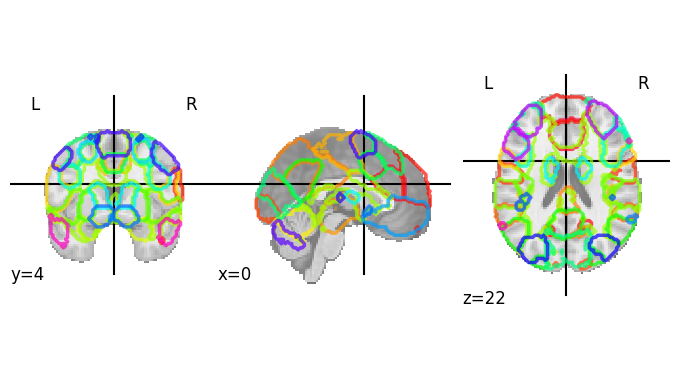

In [34]:
from nilearn.plotting import plot_prob_atlas

mask_nifti = mask_x.to_nifti()
view = plot_prob_atlas(mask_nifti, threshold=None)  # Use threshold=None to display the whole mask
view

**Extract data in ROI**

In [8]:
#func_ana = Brain_Data(ana_files)
n_subj = 6; # limit computation time

roi = 4
roi_mask = mask_x[roi]

#file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*nii.gz'))
ana_data = []
for count, (sub, f) in enumerate(zip(subjects, ana_files)):
    if count > n_subj:
        break
    else:    
        print(sub)
        data = Brain_Data(f)
        ana_data.append(data.apply_mask(roi_mask))

sub-09
sub-03
sub-22
sub-28
sub-17
sub-41
sub-36


**Hyper align**

In [11]:
ana_data

[nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

In [12]:
hyperalign = align(ana_data[:6], method='procrustes')

In [34]:
hyperalign

{'transformed': [nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)],
 'common_model': nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 'transformation_matrix': [nltools.data.brain_data.Brain_Data(data=(2786, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain

Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.3')

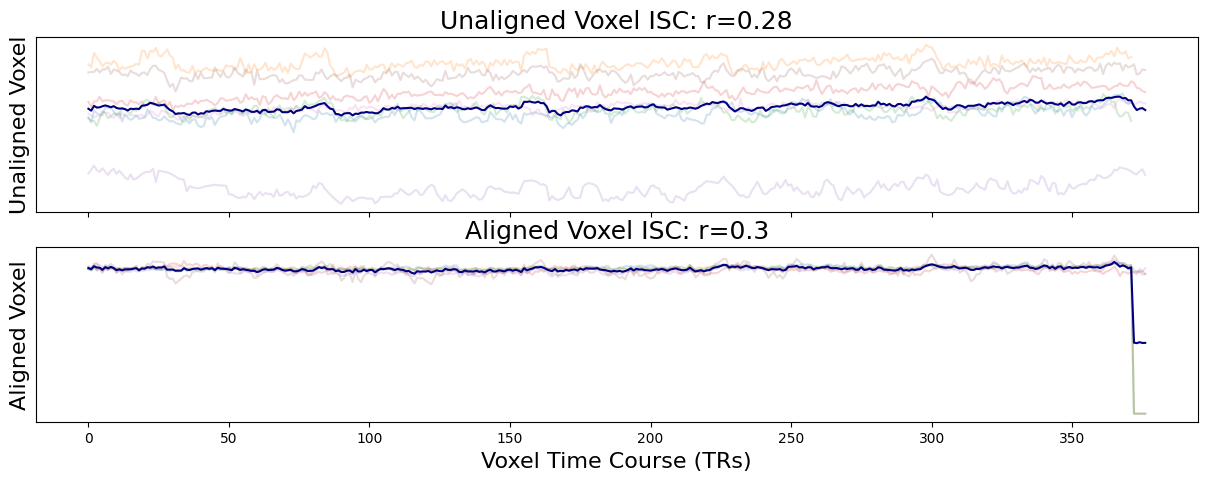

In [17]:
voxel_index = 50

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in ana_data]).T # x is subject i
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


**ISC distribution : N voxel pair-wise correlation, meaned**

Unaligned voxel ISC

In [22]:
ana_data[0].data.flatten().shape

(1036392,)

In [23]:
ana_data[0].data.shape[1]

2786

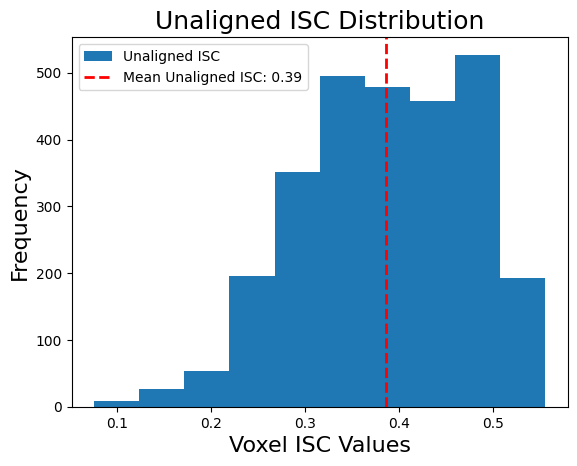

Mean Unaligned ISC (voxel-wise): 0.39


In [30]:
import numpy as np
from nltools.data import Adjacency

unaligned_isc = {}

#compute mean ISC for each unaligned voxel to plot distribution
for voxel_index in range(ana_data[0].data.shape[1]):  # Assuming all_data is a list of Brain_Data objects
    # Extract the time series for this voxel across all subjects
    voxel_time_series = np.array([x.data[:372, voxel_index] for x in ana_data])  # shape (n_subjects, n_timepoints)
    voxel_corr = np.corrcoef(voxel_time_series)  # matrix shape (n_subjects, n_subjects)
    triu_indices = np.triu_indices_from(voxel_corr, k=1) # mean of triangle
    unaligned_isc[voxel_index] = voxel_corr[triu_indices].mean()

plt.hist(unaligned_isc.values(),label='Unaligned ISC')
plt.axvline(x=np.mean(list(unaligned_isc.values())), linestyle='--', color='red', linewidth=2, label=f'Mean Unaligned ISC: {np.mean(list(unaligned_isc.values())):.2f}')
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Unaligned ISC Distribution', fontsize=18)
plt.legend()
plt.show()

# Print the mean ISC value for unaligned data
print(f"Mean Unaligned ISC (voxel-wise): {np.mean(list(unaligned_isc.values())):.2f}")


Mean ISC: 0.33


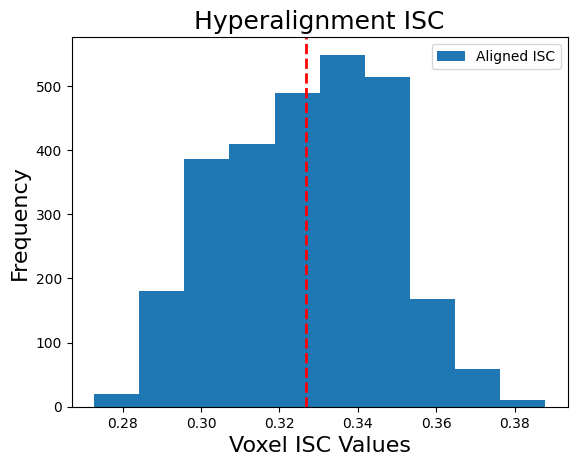

In [32]:
plt.hist(hyperalign['isc'].values(), label='Aligned ISC')
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.legend()
plt.title('Hyperalignment ISC', fontsize=18)

print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

**Compare a slice of ROI**

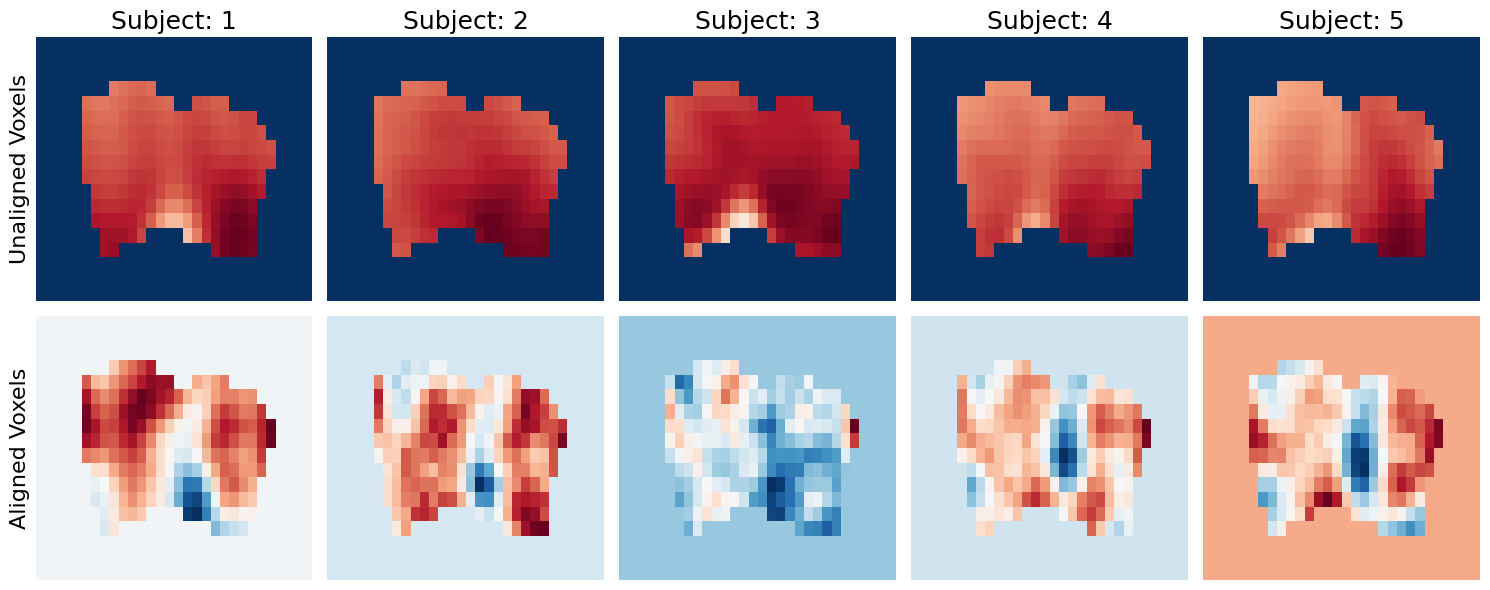

In [33]:
tr_index = 100

f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    sns.heatmap(np.rot90(ana_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])

a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

plt.tight_layout()

In [ ]:
data_dir = '/data/rainville/Hypnosis_ISC/4D_data/segmented'